# EMG Data Processing
- In this notebook, the EMG data from the 1022102cFnorm.csv is used to perform XGBoost analysis.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization (e.g plot graphs)
import seaborn as sns #  creates informative statistical graphics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, StratifiedKFold, RandomizedSearchCV, LeaveOneOut, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import tensorflow as tf # building and training neural networks
import xgboost as xgb # for building and training neural networks
# from digital_processing import bp_filter, notch_filter, plot_signal
# from feature_extraction import features_estimation
import os
from xgboost import plot_importance
import neurokit2 as nk
import datetime as dt
import matplotlib.ticker as ticker

### Loading data

In [2]:
data = pd.read_csv('../data/p1_wk1/1222325cFnorm.csv')
loc = pd.read_csv('../data/p1_wk1/1222325clocation_Bites.csv')

# print(df.head())
print(data.shape, loc.shape)
# print(df.describe)

data.describe() # describes the data

(70663676, 8) (3, 4)


,MR,ML,SU,Microphone,Eye,ECG,Pressure Sensor,Unnamed: 7
count,7.066368e+07,7.066368e+07,7.066368e+07,7.066368e+07,7.066368e+07,7.066368e+07,0.0,0.0
mean,-4.561777e-09,3.098720e-10,-9.445913e-10,-3.342267e-04,-5.703959e-04,3.598784e-04,NaN,NaN
std,1.000000e+00,9.999999e-01,1.000000e+00,4.277058e-04,1.571628e-02,5.711729e-03,NaN,NaN
min,-3.953000e+01,-4.270700e+02,-6.841000e+01,-4.113100e-01,-1.000000e+00,-3.011500e-01,NaN,NaN
25%,-2.322400e-01,-2.052500e-01,-8.749600e-02,-3.553600e-04,-1.561600e-03,-8.032300e-04,NaN,NaN
50%,-2.723750e-04,-2.481050e-04,5.490500e-05,-3.402200e-04,-4.346400e-04,2.172000e-04,NaN,NaN
75%,2.363000e-01,2.055300e-01,8.871600e-02,-3.289000e-04,7.340900e-04,1.225500e-03,NaN,NaN
max,4.090400e+01,9.234800e+02,4.173300e+01,7.000000e-01,1.000000e+00,2.636300e-01,NaN,NaN


In [ ]:
data_itr = pd.read_csv('../data/p1_w1/1022102cFnorm.csv',iterator=True, chunksize=1000000, usecols=['MR','ML'])
chunk = data_itr.get_chunk()
print(chunk.shape)
chunk.describe()

(1000000, 2)


,MR,ML
count,1.000000e+06,1.000000e+06
mean,2.235541e-07,1.437292e-07
std,2.385875e-01,1.989998e-01
min,-1.249900e+01,-6.510200e+00
25%,-1.877000e-02,-1.941000e-02
50%,-7.908100e-04,6.093400e-04
75%,1.633000e-02,2.080525e-02
max,2.075600e+01,5.087400e+00


### Resampling

In [3]:
org_freq = 2000
tgt_freq = 1000
dsample_rate = np.round(org_freq / tgt_freq).astype("int")

# df = nk.signal_resample(data.copy(), sampling_rate=org_freq, desired_sampling_rate=tgt_freq, method="pandas")
df = data.iloc[::dsample_rate, :].copy()
print(df.shape)
df.describe()

(35331838, 8)


,MR,ML,SU,Microphone,Eye,ECG,Pressure Sensor,Unnamed: 7
count,3.533184e+07,3.533184e+07,3.533184e+07,3.533184e+07,3.533184e+07,3.533184e+07,0.0,0.0
mean,-4.221033e-09,-3.842576e-10,2.718143e-10,-3.342308e-04,-5.703952e-04,3.598792e-04,NaN,NaN
std,1.000000e+00,9.999900e-01,1.000001e+00,4.250657e-04,1.571633e-02,5.711903e-03,NaN,NaN
min,-3.915900e+01,-4.270700e+02,-6.203000e+01,-4.113100e-01,-1.000000e+00,-3.011500e-01,NaN,NaN
25%,-2.322300e-01,-2.052200e-01,-8.750900e-02,-3.553600e-04,-1.561600e-03,-8.033500e-04,NaN,NaN
50%,-2.726050e-04,-2.366350e-04,5.534050e-05,-3.402200e-04,-4.345200e-04,2.172000e-04,NaN,NaN
75%,2.362800e-01,2.055200e-01,8.871600e-02,-3.289000e-04,7.342100e-04,1.225600e-03,NaN,NaN
max,4.090400e+01,9.234800e+02,4.173300e+01,7.000000e-01,1.000000e+00,2.636300e-01,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35331838 entries, 0 to 70663674
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   MR               float64
 1   ML               float64
 2   SU               float64
 3   Microphone       float64
 4   Eye              float64
 5   ECG              float64
 6   Pressure Sensor  float64
 7   Unnamed: 7       float64
dtypes: float64(8)
memory usage: 2.1 GB


### Visualization of the normalized data

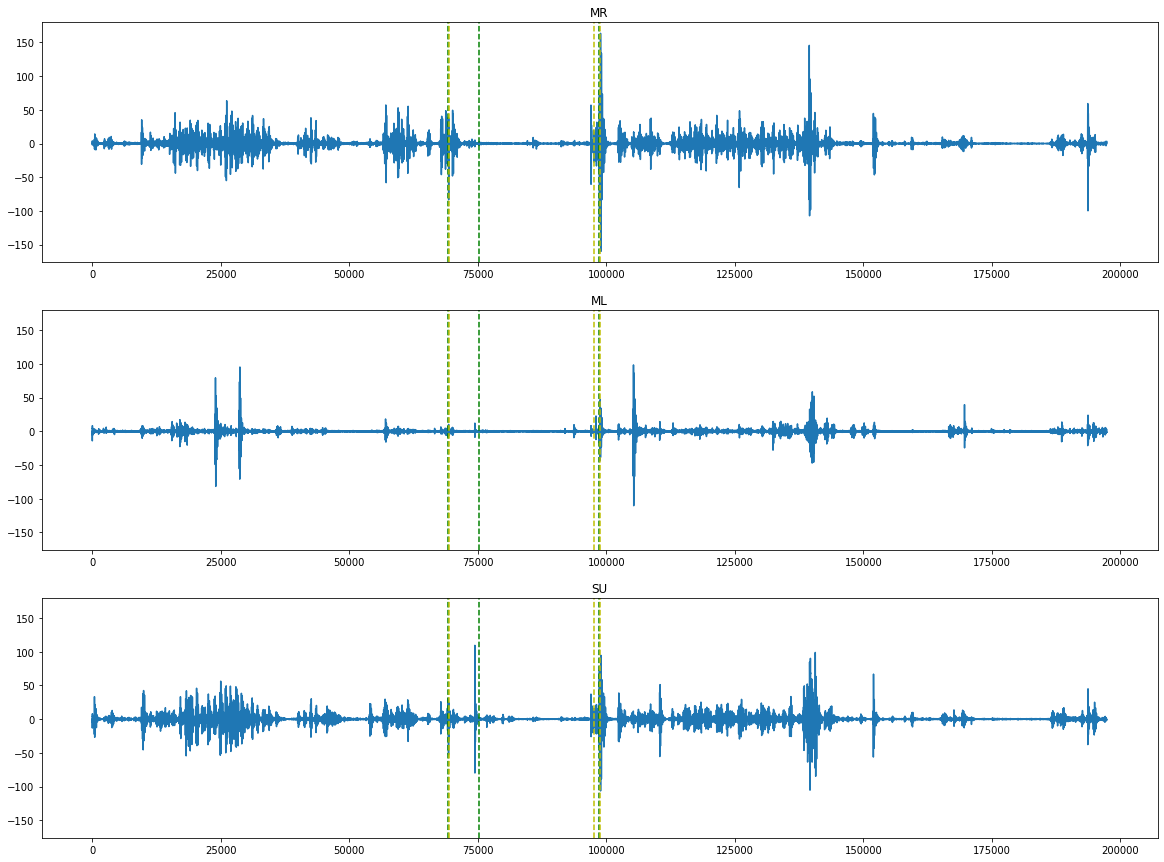

In [7]:
range_min = 0
range_max = loc.iloc[2,1]
def plot_data(data, loc):    
    fig, axes = plt.subplots(3,1, figsize=(20, 15), sharey=True) # ensures that all subplots share the same x-axis and y-axis
    for i in range(3):
        axes[i].plot(data.iloc[range_min:range_max,i])
        axes[i].set_title(data.columns[i])
        for j in range(loc.shape[0]):
            axes[i].axvline(x=loc.iloc[j,0], color='g', linestyle='--')
            axes[i].axvline(x=loc.iloc[j,1], color='y', linestyle='--')
        
plot_data(df, loc)

### Data Preprocessing

In [4]:
range_min = 0
range_max = loc.iloc[2,1]

bites = np.zeros(data.shape[0], dtype=int)
for i in range(1, range_max*dsample_rate):
    if i < loc.iloc[0,0] or (i > loc.iloc[0,1] and i < loc.iloc[1,0]) or (i > loc.iloc[1,1] and i < loc.iloc[2,0]) or i > loc.iloc[2,1]:
        bites[i] = 0
    else:
        bites[i] = 1
df.loc[:,'Bites'] = bites[::dsample_rate]
x = df.iloc[range_min:range_max,:2].copy()
y = df.iloc[range_min:range_max,-1].copy()
print(x.shape)
print(y.shape)

(37081, 2)
(37081,)


In [5]:
x = np.array(x.values.tolist())
y = np.array(y.values.tolist())

### Sliding window

In [72]:
window_size = 1000  # Size of the sliding window
stride = 50  # Stride or step size between windows
channel = 0  # Channel to be used for training

# Generate sliding window subsequences
windows = []
labels = []
for i in range(0, len(x) - window_size + 1, stride):
    window = x.iloc[i:i+window_size, channel].copy()
    windows.append(window)
    labels.append(1 if np.mean(y.iloc[i:i+window_size-1])>=0.5 else 0)

# Convert to numpy arrays
windows = np.array(windows)
labels = np.array(labels)
# windows = pd.concat(windows)
# labels = pd.Series(labels)

# Flatten the windows to match the input shape of XGBoost
flattened_windows = windows.reshape(windows.shape[0], -1)
print(flattened_windows.shape)


(481, 1000)


In [26]:
x_train, x_test, y_train, y_test = train_test_split(flattened_windows, labels, test_size=0.2, random_state=0) # Split data for test and training

SC = StandardScaler()
x_train = pd.DataFrame(SC.fit_transform(x_train))
x_test = pd.DataFrame(SC.transform(x_test))

NameError: name 'flattened_windows' is not defined

### Split dataset

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) # Split data for test and training

SC = StandardScaler()
x_train = pd.DataFrame(SC.fit_transform(x_train))
x_test = pd.DataFrame(SC.transform(x_test))

### Get Best parameters

In [8]:
params = {
    "max_depth" : [3, 5, 7],
    "max_leaf_nodes" : [15, 20, 25]
}

model1 = DTC()
clf = GridSearchCV(model1, params, scoring = "accuracy", cv=5)

clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'max_leaf_nodes': [15, 20, 25]},
             scoring='accuracy')

In [9]:
res = clf.cv_results_

for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Parameters:{'max_depth': 3, 'max_leaf_nodes': 15} Mean_score: 0.8455466666666667 Rank: 7
Parameters:{'max_depth': 3, 'max_leaf_nodes': 20} Mean_score: 0.8455466666666667 Rank: 7
Parameters:{'max_depth': 3, 'max_leaf_nodes': 25} Mean_score: 0.8455466666666667 Rank: 7
Parameters:{'max_depth': 5, 'max_leaf_nodes': 15} Mean_score: 0.8469866666666667 Rank: 6
Parameters:{'max_depth': 5, 'max_leaf_nodes': 20} Mean_score: 0.8474133333333332 Rank: 4
Parameters:{'max_depth': 5, 'max_leaf_nodes': 25} Mean_score: 0.8471466666666666 Rank: 5
Parameters:{'max_depth': 7, 'max_leaf_nodes': 15} Mean_score: 0.8485866666666666 Rank: 3
Parameters:{'max_depth': 7, 'max_leaf_nodes': 20} Mean_score: 0.8488 Rank: 2
Parameters:{'max_depth': 7, 'max_leaf_nodes': 25} Mean_score: 0.8495466666666666 Rank: 1


In [10]:
print(clf.best_estimator_)

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=25)


In [11]:
def plot_learning_curve(estimator, x, y, title):

  train_sizes, train_scores, test_scores, _, _ = learning_curve(estimator,
    x, y, return_times=True)

  fig, axes = plt.subplots(1, 1, figsize = (10, 5))

  axes.set_title(title)
  axes.plot
  axes.set_xlabel("Training examples")
  axes.set_ylabel("Score")


  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  # Plot learning curve
  axes.grid()
  axes.fill_between(
      train_sizes,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.1,
      color="r",
  )
  axes.fill_between(
      train_sizes,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.1,
      color="g",
  )
  axes.plot(
      train_sizes, train_scores_mean, "o-", color="r", label="Training score"
  )
  axes.plot(
      train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
  )
  axes.legend(loc="best")

  plt.show()

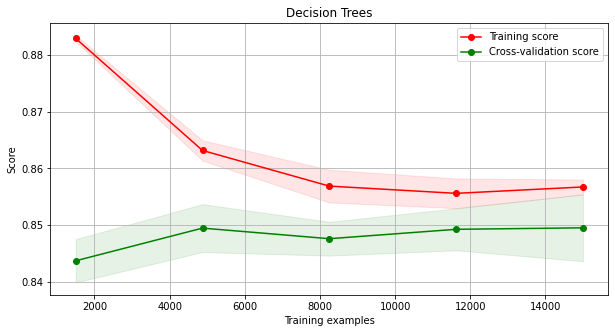

0.8563733333333333


In [12]:
model1 = clf.best_estimator_

model1.fit(x_train, y_train)

plot_learning_curve(model1, x_train, y_train, "Decision Trees")

print(model1.score(x_train, y_train))

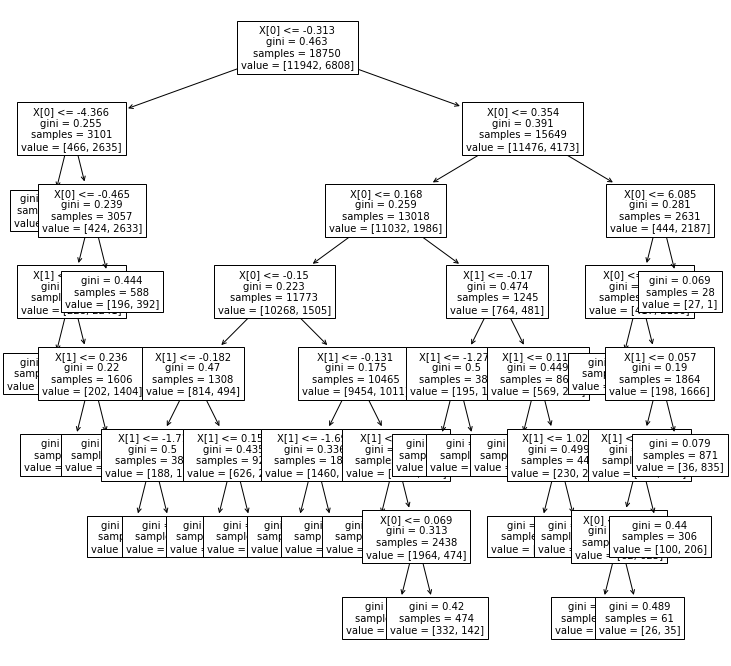

In [13]:
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(model1, fontsize=10)
plt.show()

In [14]:
params = {
        'learning_rate': [0.1, 0.5, 0.8],   # shrinkage coefficient - "v" [0,1]
        'subsample': [0.6, 0.8, 1.0],     # concept of bagging in xgboost- row sampling
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

model_XGB = xgb.XGBClassifier(n_estimators=100, objective='multi:softmax', num_class=20, silent=False) #100 base learners, for multiclass- log loss does not work. need softmax
folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(model_XGB, param_distributions=params, n_iter=10, scoring='accuracy', n_jobs=4, cv=skf.split(x_train,y_train), verbose=3, random_state=1001 )

# number of iterations=10, n_jobs=4= it will try to distribute it across 4 cores

start = dt.datetime.now()
random_search.fit(x_train, y_train)
end = dt.datetime.now()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[16:46:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:46:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.
[16:46:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.


[16:46:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/3] END colsample_bytree=0.6, learning_rate=0.8, max_depth=4, subsample=1.0;, score=0.843 total time=   1.3s
[16:46:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are no

In [15]:
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best hyperparameters:
{'subsample': 0.6, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


### Train whole data

In [7]:
best_xgb = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic',
    eval_metric='logloss', subsample=0.6, max_depth=3, learning_rate=0.1, colsample_bytree=1.0)
best_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [12]:
print(f"Time taken for training : {end - start}\nTraining accuracy:{best_xgb.score(x_train, y_train)}\nTest Accuracy: {best_xgb.score(x_test, y_test)}")

NameError: name 'end' is not defined

[0.1868674 0.8131326]


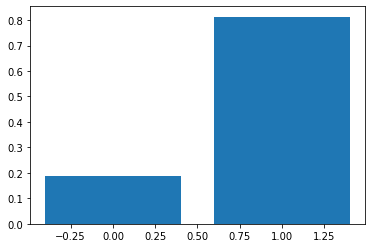

In [9]:
print(best_xgb.feature_importances_)

plt.bar(range(len(best_xgb.feature_importances_)), best_xgb.feature_importances_)
plt.show()

### Batch

In [9]:
batch_size = 1000
intervals = 100
num_batches = len(x) // batch_size
col_size = 3

best_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.6,
    colsample_bytree=1.0
)

first = True 
for i in range(1):
    for start in range(0, len(x_train), batch_size):
        if first:
            first = False
            best_xgb.fit(x_train[start:start+batch_size], y_train[start:start+batch_size])
            continue
        best_xgb.fit(x_train[start:start+batch_size], y_train[start:start+batch_size], xgb_model=best_xgb)



### Model

In [74]:
model_XGB = xgb.XGBClassifier()
model_RF = RandomForestClassifier(n_estimators = 100, random_state=0)
model_XGB.fit(x_train, y_train)
model_RF.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [75]:
y_pred = model_RF.predict(x_test)
y_p = model_XGB.predict(x_test)
accuracy = accuracy_score(y_test, [q for q in y_pred])
accuracy_p = accuracy_score(y_test, [r for r in y_p])
print("Accuracy for RF: %.2f%%" % (accuracy * 100.0))
print("Accuracy for XGB: %.2f%%" % (accuracy_p * 100.0))

Accuracy for RF: 97.94%
Accuracy for XGB: 97.94%


### Confusion Matrix

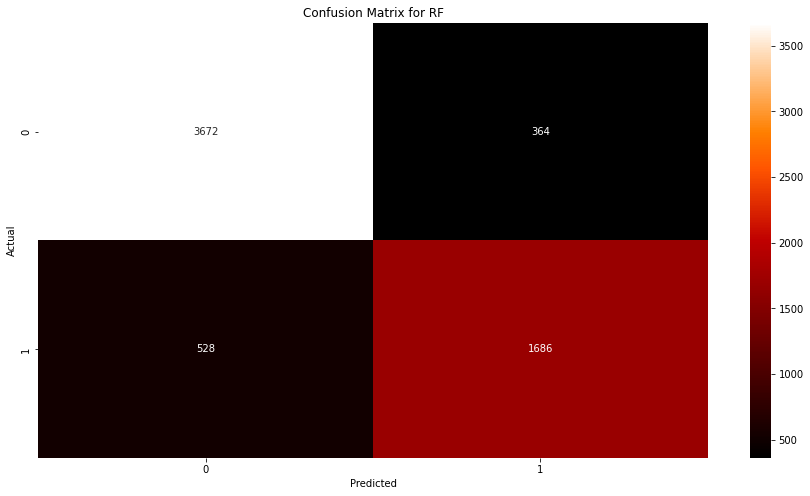

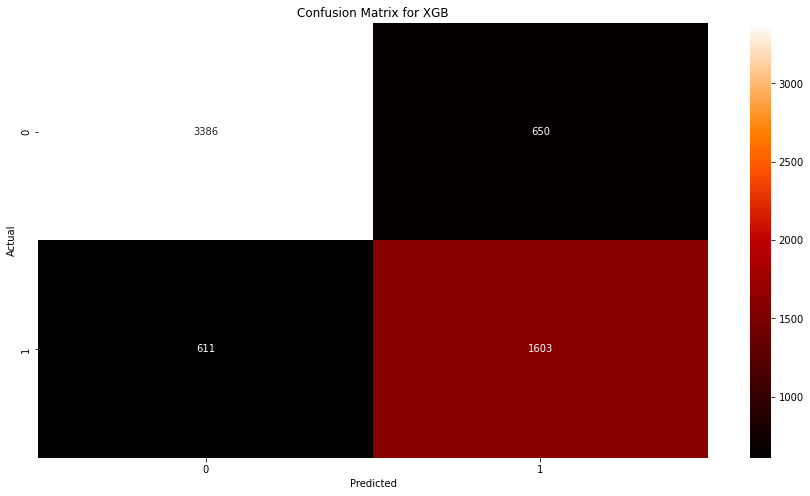

In [43]:
y_true = np.array(y_test)
y_pred = np.array(model_RF.predict(x_test))
y_pred_xgb = np.array(model_XGB.predict(x_test))

cm = confusion_matrix(y_true, y_pred)
cm_xgb = confusion_matrix(y_true, y_pred_xgb)
plt.figure(figsize = (15,8))
sns.heatmap(cm, annot=True, fmt='g', cmap='gist_heat', cbar=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for RF")
plt.show()
plt.figure(figsize = (15,8))
sns.heatmap(cm_xgb, annot=True, fmt='g', cmap='gist_heat',cbar=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGB")
plt.show()

### Pick channel and Predict

['0', '1']


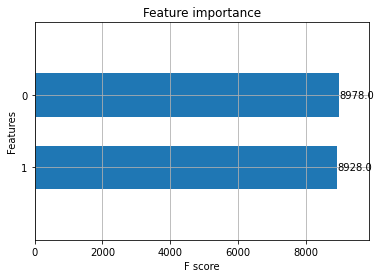

In [10]:
_ = plot_importance(best_xgb, height=0.6)
# model_XGB.get_booster().feature_names = ['EMG1', 'EMG2', 'EMG3']
print(best_xgb.get_booster().feature_names)

In [11]:
y_p = best_xgb.predict(x_test)
accuracy_p = accuracy_score(y_test, [r for r in y_p])
print("Accuracy for XGB: %.2f%%" % (accuracy_p * 100.0))

Accuracy for XGB: 70.70%


### k-Fold

In [13]:
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=x,label=y)
p = {'n_estimators':100, 'objective':'binary:logistic',
    'eval_metric':'logloss', 'subsample':0.6, 'max_depth':3, 'learning_rate':0.1, 'colsample_bytree':1.0, 'silent':True}
xgb_cv = xgb.cv(dtrain=data_dmatrix, params=p, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

[22:11:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators", "silent" } are not used.

[22:11:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators", "silent" } are not used.

[22:11:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators", "silent" } are not used.



In [14]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.700031,0.004755,0.695614,0.006780
1,0.710784,0.003387,0.706981,0.003040
2,0.715292,0.006025,0.712269,0.008480
3,0.718892,0.003058,0.715329,0.008249
4,0.728426,0.003007,0.725949,0.003603


In [12]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
accuracies = model_selection.cross_validate(estimator = best_xgb, X = x_train, y = y_train, cv = 10, scoring=scoring)
print(accuracies['test_accuracy'].mean())
print(accuracies['test_precision'].mean())

0.7470000870442478
0.6863582451734592


### Confusion Matrix

[[0.83497053 0.16502947]
 [0.57284057 0.42715943]]


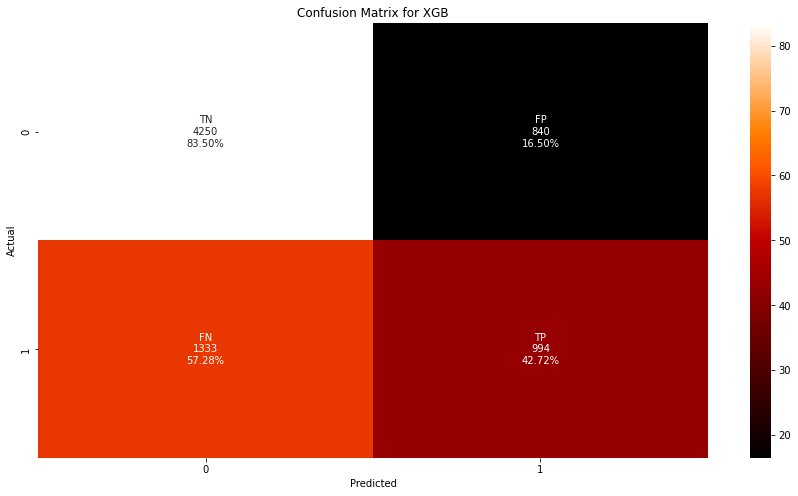

In [18]:
cm = confusion_matrix(y_test, y_p)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cmn)
group_names = ['TN','FP','FN', 'TP']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cmn.flatten()]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (15,8))
sns.heatmap(cmn*100, annot=labels, fmt='', cmap='gist_heat')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGB")
plt.show()

### LOOCV

In [15]:
# evaluate model
scores = cross_val_score(best_xgb, x, y, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

[11:48:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:48:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:48:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:48:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:48:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[11:48:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpytho

KeyboardInterrupt: 

### Prediction

In [19]:
DATA_PATH = "/Users/nanashuka/Document/Zurich/UZH/master_project/sensor-data-analysis-pipeline/back-end/data/"
p = 1
w = 1
n = '1222325'

In [20]:
x_p = df.iloc[:,:2].copy()
x_p = np.array(x_p.values.tolist())
y_p = best_xgb.predict(x_p)
print(y_p)
print(len(y_p))

[0 1 1 ... 0 0 0]
35331838


In [21]:
y_p_mix = []
i = 0
event = 0
while i < len(y_p):
    y_sum = y_p[i];
    cnt = 1;
    for j in range(1, 5000):
        if(i+j >= len(y_p)):
            break;
        y_sum += y_p[i+j];
        cnt += 1;
    if y_sum/cnt >= 0.5:
        if(len(y_p_mix)==0 or y_p_mix[-1] != 10):
            event += 1
        y_p_mix.extend([10]*cnt);
    else:
        y_p_mix.extend([0]*cnt);
    i += cnt;
    # print(i)
    # print("cnt: ", cnt)
# print(y_p_mix)
print(len(y_p_mix))
print(event)

35331838
6


In [26]:
y_p_mix = []
i = 0
event = 0
dur = 0
while i < len(y_p):
    y_sum = y_p[i];
    cnt = 1;
    for j in range(1, int(5*1000)):
        if(i+j >= len(y_p)):
            break;
        y_sum += y_p[i+j];
        cnt += 1;
    if y_sum/cnt >= 0.2:
        if(len(y_p_mix)==0 or y_p_mix[-1] != 10):
            event += 1
            dur = cnt
            print("current dur:", dur/1000)
        elif(y_p_mix[-1] == 10):
            dur += cnt
            print("update dur:", dur/1000)
        y_p_mix.extend([10]*cnt);
    else:
        y_p_mix.extend([0]*cnt);
    i += cnt;
    print(i)
print(event)

current dur: 5.0
5000
update dur: 10.0
10000
update dur: 15.0
15000
update dur: 20.0
20000
25000
current dur: 5.0
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000
420000
425000
430000
435000
440000
445000
450000
455000
460000
465000
470000
475000
480000
485000
490000
495000
500000
505000
510000
515000
520000
525000
530000
535000
540000
545000
550000
555000
560000
565000
570000
575000
580000
585000
590000
595000
600000
605000
610000
615000
620000
625000
630000
635000
640000
645000
650000
655000
660000
665000
6700

: 

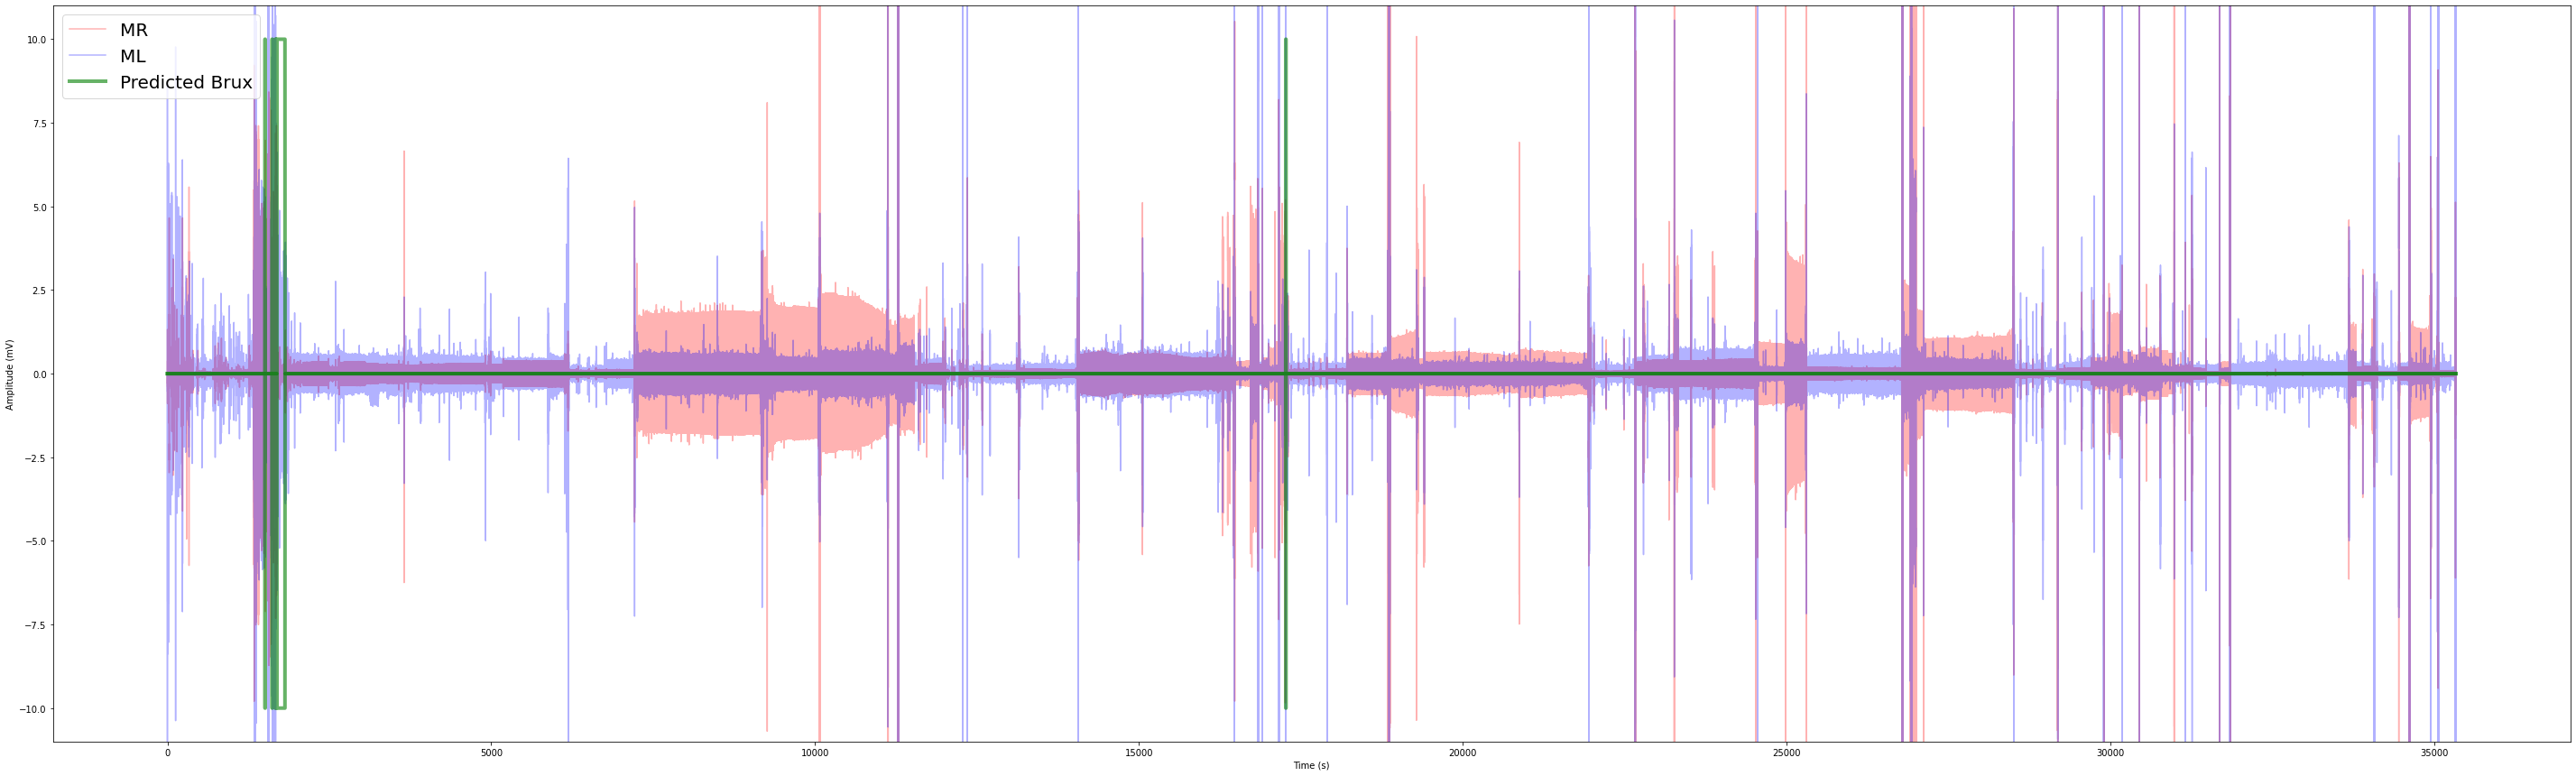

In [23]:
def plot_predict(data, pred):    
    fig, ax = plt.subplots(1,1, figsize=(50, 15), sharey=True) # ensures that all subplots share the same x-axis and y-axis
    # for i in range(2):
    X = np.linspace(0, df.shape[0]/tgt_freq, df.shape[0])
    ax.plot(X, data[:,0],color='r',alpha=0.3, label='MR')
    ax.plot(X, data[:,1],color='b',alpha=0.3, label='ML')
    ax.plot(X, pred[:],color='g',alpha=0.6,linewidth=4, label='Predicted Brux')
    neg_pred = [-x for x in pred]
    ax.plot(X, neg_pred[:],color='g',alpha=0.6,linewidth=4)
    
    # for j in range(len(pred)):
    #     if(pred[j] > 0):
    #         ax.axvline(x=j/tgt_freq, color='g',alpha=0.7)
    
    # plt.title(i)
    # ax.set_title('Signals and Predicted Bites for Whole Night')
    ax.legend(loc='upper left', fontsize=20)
    ax.set_ylim(-11,11)
    # ax.xaxis.set_ticks(np.arange(0, 1800000, 1))
    # ax.xaxis.set_ticklabels(np.arange(0, 1800, 0.001).round(1))
    # ticks_x = ticker.FuncFormatter(numfmt)
    # ax.xaxis.set_minor_formatter(ticks_x)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (mV)')
        # for j in range(loc.shape[0]):
        #     axes[i].axvline(x=loc.iloc[j,0], color='g', linestyle='--')
        #     axes[i].axvline(x=loc.iloc[j,1], color='y', linestyle='--')
    
    plt.savefig(DATA_PATH+'p'+str(p)+'_wk'+str(w)+'/'+str(n)+'.png',bbox_inches='tight')
    plt.show()
        
plot_predict(x_p, y_p_mix)

In [16]:
best_xgb.save_model("p1.json")
model2 = xgb.XGBClassifier()
model2.load_model("p1.json")

In [36]:
data = pd.read_csv('../data/p1_wk1/1022102cFnorm.csv')
loc = pd.read_csv('../data/p1_wk1/1022102clocation_Bites.csv')
org_freq = 2000
tgt_freq = 1000
dsample_rate = np.round(org_freq / tgt_freq).astype("int")

# df = nk.signal_resample(data.copy(), sampling_rate=org_freq, desired_sampling_rate=tgt_freq, method="pandas")
df = data.iloc[::dsample_rate, :].copy()
range_min = 0
range_max = loc.iloc[2,1]

bites = np.zeros(data.shape[0], dtype=int)
for i in range(1, range_max*dsample_rate):
    if i < loc.iloc[0,0] or (i > loc.iloc[0,1] and i < loc.iloc[1,0]) or (i > loc.iloc[1,1] and i < loc.iloc[2,0]) or i > loc.iloc[2,1]:
        bites[i] = 0
    else:
        bites[i] = 1
df.loc[:,'Bites'] = bites[::dsample_rate]

(38254, 2)
(38254,)


In [37]:
print(df.describe())
x_new = df.iloc[range_min:range_max,:2].copy()
y_new = df.iloc[range_min:range_max,-1].copy()
print(x_new.shape)
print(y_new.shape)

                 MR            ML            SU    Microphone           Eye  \
count  3.707776e+07  3.707776e+07  3.707776e+07  3.707776e+07  3.707776e+07   
mean   1.026545e-09 -1.803854e-09  1.063062e-08 -3.645998e-04 -5.591799e-04   
std    9.999740e-01  9.999532e-01  9.999966e-01  1.514262e-04  1.506342e-02   
min   -4.477700e+02 -7.358500e+02 -2.006100e+02 -1.562600e-01 -6.956700e-01   
25%   -1.388600e-02 -3.572500e-02 -1.007000e-01 -3.746700e-04 -1.203100e-03   
50%   -9.912750e-05  1.841000e-04 -1.034650e-04 -3.552400e-04 -5.472900e-04   
75%    1.370200e-02  3.561300e-02  1.001400e-01 -3.382000e-04  4.458400e-05   
max    2.822900e+02  5.069800e+02  2.581800e+02  2.881800e-01  7.554900e-01   

                ECG  Pressure Sensor  Unnamed: 7         Bites  
count  3.707776e+07              0.0         0.0  3.707776e+07  
mean   6.660691e-04              NaN         NaN  2.462932e-04  
std    5.071532e-03              NaN         NaN  1.569180e-02  
min   -3.078000e-02         

In [33]:
x_new = np.array(x_new.values.tolist())
y_new = np.array(y_new.values.tolist())
print(y_new)

[0 0 0 ... 0 0 0]


In [38]:
x_new_train, x_new_test, y_new_train, y_new_test = train_test_split(x_new, y_new, test_size=0.25) # Split data for test and training

SC = StandardScaler()
x_new_train = pd.DataFrame(SC.fit_transform(x_new_train))
x_new_test = pd.DataFrame(SC.transform(x_new_test))

In [43]:
model2.fit(x_new_train, y_new_train, xgb_model = "p1.json")
model2.save_model("p1.json")

[22:49:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [1]:
accuracies = cross_val_score(estimator = model2, X = x_train, y = y_train, cv = 10)
print(accuracies.mean(), accuracies.std())

NameError: name 'cross_val_score' is not defined

In [45]:
data = pd.read_csv('../data/p1_wk1/0901260cFnorm.csv')
loc = pd.read_csv('../data/p1_wk1/0901260clocation_Bites.csv')
org_freq = 2000
tgt_freq = 1000
dsample_rate = np.round(org_freq / tgt_freq).astype("int")

# df = nk.signal_resample(data.copy(), sampling_rate=org_freq, desired_sampling_rate=tgt_freq, method="pandas")
df = data.iloc[::dsample_rate, :].copy()
range_min = 0
range_max = loc.iloc[2,1]

bites = np.zeros(data.shape[0], dtype=int)
for i in range(1, range_max*dsample_rate):
    if i < loc.iloc[0,0] or (i > loc.iloc[0,1] and i < loc.iloc[1,0]) or (i > loc.iloc[1,1] and i < loc.iloc[2,0]) or i > loc.iloc[2,1]:
        bites[i] = 0
    else:
        bites[i] = 1
df.loc[:,'Bites'] = bites[::dsample_rate]

In [46]:
print(df.describe())
x_new2 = df.iloc[range_min:range_max,:2].copy()
y_new2 = df.iloc[range_min:range_max,-1].copy()
print(x_new2.shape)
print(y_new2.shape)

                 MR            ML            SU    Microphone           Eye  \
count  3.140544e+07  3.140544e+07  3.140544e+07  3.140544e+07  3.140544e+07   
mean   5.982562e-10  8.854471e-11  6.837482e-09 -3.441143e-04 -5.802316e-04   
std    9.999986e-01  1.000001e+00  9.999923e-01  9.878980e-05  8.800276e-04   
min   -3.342500e+02 -3.689400e+02 -2.904800e+02 -7.848900e-02 -9.742700e-02   
25%   -4.411900e-02 -2.003300e-01 -5.677000e-02 -3.571500e-04 -5.961700e-04   
50%   -1.580850e-04  3.297800e-04 -9.874700e-05 -3.404600e-04 -5.668400e-04   
75%    4.387300e-02  2.009100e-01  5.671300e-02 -3.268700e-04 -5.363200e-04   
max    2.498800e+02  7.036000e+02  3.792700e+02  7.231200e-02  7.518500e-02   

                ECG  Pressure Sensor  Unnamed: 7         Bites  
count  3.140544e+07              0.0         0.0  3.140544e+07  
mean   3.755876e-04              NaN         NaN  3.606700e-04  
std    2.846167e-03              NaN         NaN  1.898789e-02  
min   -3.347800e-02         

In [47]:
x_new2 = np.array(x_new2.values.tolist())
y_new2 = np.array(y_new2.values.tolist())

In [48]:
x_new_train2, x_new_test2, y_new_train2, y_new_test2 = train_test_split(x_new2, y_new2, test_size=0.25) # Split data for test and training

SC = StandardScaler()
x_new_train2 = pd.DataFrame(SC.fit_transform(x_new_train2))
x_new_test2 = pd.DataFrame(SC.transform(x_new_test2))

In [49]:
model3 = xgb.XGBClassifier()
# model2.load_model("p1.json")
model3.fit(x_new_train2, y_new_train2, xgb_model = "p1.json")
model3.save_model("p1.json")

In [52]:
accuracies = cross_val_score(estimator = model3, X = x_train, y = y_train, cv = 10)
print(accuracies.mean(), accuracies.std())

0.741603739661992 0.004749217398374427
